In [2]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split
import os
import xarray as xr
import matplotlib.pyplot as plt
import copy
import random

#### Load and pre-process data into DataLoader

In [3]:
## load data and place into required form
# input data must be of the form (i, channel, x_data, y_data)

sample_percent = 1# percent of dataset to sample
folder_path = 'lustre_scratch/data/South_Africa_West_Coast' # folder containing your .nc files

channels = ['gradient']
channel_data_paths = []
for channel in channels: 
    channel_data_paths.append(os.path.join(folder_path, channel))

ds = []

for channel_path in channel_data_paths:
    file_list = []
    for file in os.listdir(channel_path): 
        if file.endswith('.nc'): 
            file_list.append(os.path.join(channel_path,file))
    # now sample from valid .nc files
    N_files = len(file_list)
    sample_indices = random.sample(range(N_files), int(sample_percent*N_files))
    ds_list = []
    for index in sample_indices: 
        ds_list.append(xr.open_dataset(file_list[index]))
    ds_temp = xr.concat(ds_list, dim = 'i') # concat all months into single ds
    # now isolate only the sstL4/gRsst data into a dataset
    if channel_path.endswith('absolute'):
        ds_temp = xr.Dataset({
            "sstL4": ds_temp.sstL4,
            "gRsst": ds_temp.gRsst}) # isolate only sstL4 and gRsst
        ds.append(ds_temp.expand_dims(dim='channel', axis=1))
    elif channel_path.endswith('gradient'):
        ds_gr = xr.concat([ds_temp.gRsst_x_grad, ds_temp.gRsst_y_grad], dim = 'channel').transpose("i","channel","y","x")
        ds_l4 = xr.concat([ds_temp.sstL4_x_grad, ds_temp.sstL4_y_grad], dim = 'channel').transpose("i","channel","y","x")
        ds.append(xr.Dataset({
            "gRsst": ds_gr,
            "sstL4": ds_l4}))

ds = xr.concat(ds, dim='channel') # concat all collected channels into single ds

    
def img_normalise(arr, clipped_gradients = True, normalise_type = None):
    if clipped_gradients:
        mini = -1
        maxi = 1
    else: 
        mini = arr.min(dim={'x','y','i'}) #min for each image in each channel: shape (i, channel)
        maxi = arr.max(dim={'x','y','i'})
    if normalise_type == 'zero_one':
        # 0-1 normalise data
        # use this if you will input your data as numpy arrays
        arr = (arr-mini)/(maxi-mini) #normalise each channel to 0-255
    elif normalise_type == 'tensor': 
        # normalise to 0-1 then convert to image values. 
        # use if you plan to use torch.transforms
        arr = 255*(arr-mini)/(maxi-mini) #normalise each channel to 0-255
    return arr

ds = xr.Dataset({"sstL4": img_normalise(ds.sstL4, clipped_gradients = True, normalise_type = 'zero_one'),
                 "gRsst": img_normalise(ds.gRsst, clipped_gradients = True, normalise_type = 'zero_one')}) # convert to pixel values

<xarray.Dataset>
Dimensions:  (y: 48, x: 48, i: 400, channel: 2)
Coordinates:
    lat      (y) float64 -25.92 -25.88 -25.83 -25.77 ... -23.67 -23.62 -23.58
    lon      (x) float64 12.02 12.07 12.12 12.18 ... 14.23 14.27 14.32 14.38
Dimensions without coordinates: y, x, i, channel
Data variables:
    sstL4    (i, channel, y, x) float32 0.41 0.3825 0.355 ... 0.475 0.49 0.505
    gRsst    (i, channel, y, x) float32 0.513 0.4815 0.4346 ... 0.4808 0.5143


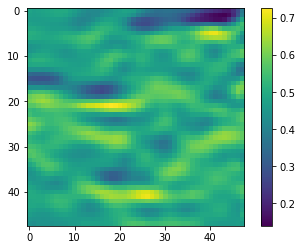

In [4]:
##check dataset format and normalisation
print(ds)
randint = np.random.randint(len(ds.sstL4))
channel = 1
fig, ax = plt.subplots() # plot a random example in a chosen channel
ax=ax.imshow(ds.sstL4.sel({'channel':channel})[randint]) # example: plot the resolved x-gradient of the 0th image
fig.colorbar(ax)

In [5]:
## define dataset class format for Torch DataLoader
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__
class MyDataset(Dataset): 
    ## this version of the class does not apply tensor transforms
    ## data inserted as numpy arrays in form (i, channel, y, x)
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data
    def __getitem__(self, index): 
        x = self.input_data[index]
        y = self.output_data[index]
        return x, y
    def __len__(self):
        return len(self.input_data)

# class MyDataset_Transform(Dataset): 
#     def __init__(self, input_data, output_data, transform):
#         self.input_data = input_data
#         self.output_data = output_data
#         self.transform = transform
#     def __getitem__(self, index): 
#         x = self.input_data[index].transpose(1,2,0) # transforms.toTensor() expects (height, width, channel)
#         y = self.output_data[index].transpose(1,2,0)
#         if self.transform: 
#             x = self.transform(x)
#             y = self.transform(y)
#         return x, y
#     def __len__(self):
#         return len(self.input_data)

In [8]:
## define transform and create dataloader
# currently in xarray form: must input as numpy arrays:

# input: x_grad, y_grad of sstL4, output: x_grad, y_grad of gRsst

input_data = ds.sstL4.sel({'channel':[0,1]}).data
output_data = ds.gRsst.sel({'channel':[0,1]}).data
print(np.shape(input_data), np.shape(output_data))

BATCH_SIZE = 2
N_data = len(input_data)

input_train, input_test, output_train, output_test = train_test_split(
    input_data, output_data, test_size=0.2
)

# transform = transforms.Compose([transforms.ToTensor()]) # .toTensor() also normalises from [0,1]

train_dataset = MyDataset(input_train, output_train)
test_dataset = MyDataset(input_test, output_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

for x, y in train_loader: 
    print(f'batch shape: input: {x.shape}, output: {y.shape}, type: {type(x)}')
    print(f'number of batches: {len(train_loader)}')
    print(f'train images: {len(train_loader.dataset)}, test images:{len(test_loader.dataset)}')
    break

(400, 2, 48, 48) (400, 2, 48, 48)
batch shape: input: torch.Size([2, 2, 48, 48]), output: torch.Size([2, 2, 48, 48]), type: <class 'torch.Tensor'>
number of batches: 160
train images: 320, test images:80


### Define Model

Layer Reference: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
- `nn.linear(input_size,output_size)`: simplest layer, a fully-connected layer performing y = Wx + b
- `nn.Conv2d(input_size,output_size,kernel_size,padding,stride)`: 2d convolutional layer. 
- `nn.max_pool2d(input_size, pooling_size=(2,2))`: group cells into 2x2 groups and output max value of cell

In [120]:
class SRCNN(nn.Module):
    def __init__(self, input_channels = 1, output_channels = 1):
        # define layers
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 128, kernel_size=9, padding=4, stride=1)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=1, padding=0, stride=1)
        self.conv3 = nn.Conv2d(64, output_channels, kernel_size=5, padding=2, stride=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


### Model, loss, optimiser

In [121]:
## remember to re-run this to restart model training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.MSELoss(reduction = 'mean')
input_channels = 2
output_channels = 2
model = SRCNN(input_channels, output_channels)
model.to(device)
LR = 1E-4
weight_decay = 1E-5
optimiser = Adam(model.parameters(), lr = LR, weight_decay=weight_decay)

### Define PSNR Accuracy Metric

In [122]:
def PSNR(model, ground_truth, prediction):
    # ground truth, pred inputted as numpy arrays of dimensions (image index, channel, y, x)
    # if channel > 1, sum MSE over each channel
    # return: avg psne for input data
    model.eval()
    m = np.ma.size(ground_truth, axis = 2)
    n = np.ma.size(ground_truth, axis = 3)
    mse_array = np.sum(((ground_truth-prediction))**2, axis = (1,2,3))/(m*n)
    mse_avg = np.mean(mse_array)
    psnr_avg = 10*np.log10(1**2/mse_avg)
    return psnr_avg

### Define Train Function

best loss observed: 0.0217

In [123]:
model_path = r'models/srcnn/srcnn'
N_train_batches = len(train_loader)
N_test_batches = len(test_loader)

def train(model_path, num_epochs = 200, test_interval = 10):
    best_loss = 1E6
    train_loss_array = []
    train_psnr_array = []
    test_loss_array = []
    test_psnr_array = []
    for epoch in range(num_epochs):
        train_running_loss = 0
        train_running_psnr = 0
        # iterate through batches and train:
        model.train()
        for i, (train_input, train_true) in enumerate(train_loader, 0): 
            train_input = train_input.to(device)
            train_true = train_true.to(device)
            plt.show()
            optimiser.zero_grad() # re-set grads from previous batch
            train_predicted = model(train_input)

            train_loss = loss_fn(train_true, train_predicted) # loss for batch
            train_loss.backward() # backpropagation
            optimiser.step() # adjust parameters based on grad

            train_running_loss += train_loss.item()
            train_running_psnr += PSNR(model, train_true.detach().cpu().numpy(), train_predicted.detach().cpu().numpy())

        epoch_loss = train_running_loss/N_train_batches
        train_loss_array.append(epoch_loss)
        train_psnr_array.append(train_running_psnr/N_train_batches)
        # check if best model has been achieved 
        if epoch_loss < best_loss: 
            best_model = copy.deepcopy(model)
            best_loss = epoch_loss
        
        # every test_interval epochs, compute the test loss. 
        if epoch % test_interval == test_interval - 1: 
            model.eval()
            test_running_loss = 0
            test_running_psnr = 0
            for i, (test_input, test_true) in enumerate(test_loader, 0): 
                test_input = test_input.to(device)
                test_true = test_true.to(device)
                with torch.no_grad(): 
                    test_predicted = model(test_input)
                    test_running_loss += loss_fn(test_predicted, test_true)
                    test_running_psnr += PSNR(model, test_true.detach().cpu().numpy(), test_predicted.detach().cpu().numpy())
            test_epoch_loss = test_running_loss / N_test_batches
            test_loss_array.append(test_epoch_loss.item())
            test_psnr_array.append(test_running_psnr/N_test_batches)
            # print stats every 10 epochs
            print(f'Epoch:{epoch+1}, Train loss: {epoch_loss}, Test Loss: {test_epoch_loss}, Best Train loss: {best_loss}')
    torch.save(best_model.state_dict(), model_path)
    return best_model, train_loss_array, train_psnr_array, test_loss_array, test_psnr_array

epochs = 1000
test_interval=10
best_model, train_loss_array, train_psnr_array, test_loss_array, test_psnr_array = train(model_path, epochs, test_interval)

Epoch:10, Train loss: 0.0017741235784342279, Test Loss: 0.0016230980399996042, Best Train loss: 0.0017741235784342279
Epoch:20, Train loss: 0.0016867288908542833, Test Loss: 0.0015445742756128311, Best Train loss: 0.0016867288908542833
Epoch:30, Train loss: 0.001660373929917114, Test Loss: 0.00152816332411021, Best Train loss: 0.0016603415653662524
Epoch:40, Train loss: 0.0016459147362184012, Test Loss: 0.0015076370909810066, Best Train loss: 0.0016459147362184012
Epoch:50, Train loss: 0.0016358612352632917, Test Loss: 0.0014956038212403655, Best Train loss: 0.0016358612352632917
Epoch:60, Train loss: 0.0016305655779433436, Test Loss: 0.0014950156910344958, Best Train loss: 0.0016301770723657683
Epoch:70, Train loss: 0.001627126456151018, Test Loss: 0.0014915739884600043, Best Train loss: 0.001627052050389466
Epoch:80, Train loss: 0.0016219789948081597, Test Loss: 0.001488398527726531, Best Train loss: 0.001621971879285411
Epoch:90, Train loss: 0.0016198754008655669, Test Loss: 0.00148

### Plot quality metrics

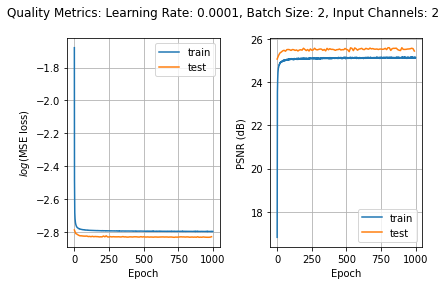

In [124]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(train_loss_array)), np.log10(train_loss_array), label = 'train')
ax[0].plot(np.array(range(len(test_loss_array)))*test_interval, np.log10(test_loss_array), label = 'test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('$log$(MSE loss)')
ax[0].grid()
ax[0].legend()
ax[1].plot(range(len(train_psnr_array)), train_psnr_array, label = 'train')
ax[1].plot(np.array(range(len(test_psnr_array)))*test_interval, test_psnr_array, label = 'test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('PSNR (dB)')
ax[1].grid()
ax[1].legend()
fig.suptitle(f'Quality Metrics: Learning Rate: {LR}, Batch Size: {BATCH_SIZE}, Input Channels: {input_channels}')
fig.savefig('plots/quality_metrics')
fig.tight_layout()

### Plot output examples

(2, 48, 48)


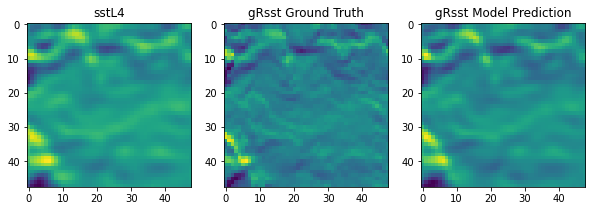

(2, 48, 48)


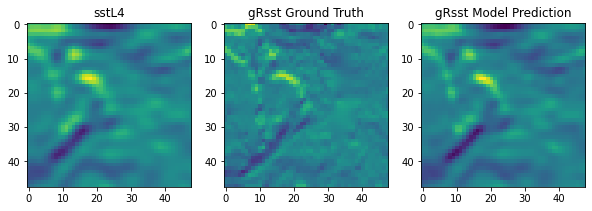

(2, 48, 48)


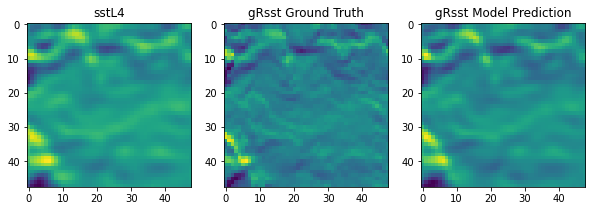

(2, 48, 48)


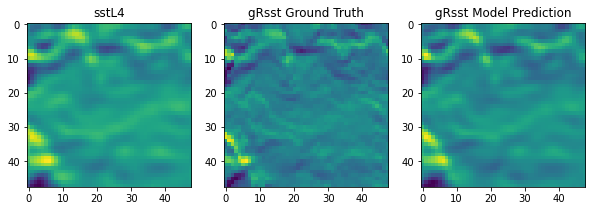

(2, 48, 48)


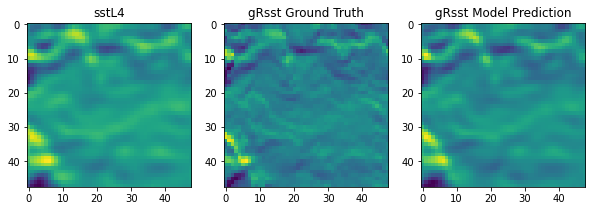

(2, 48, 48)


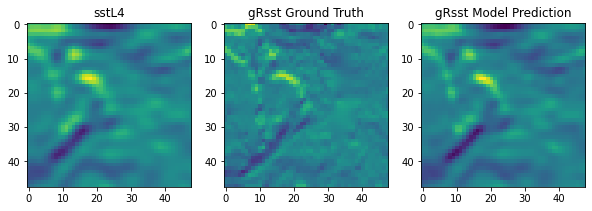

(2, 48, 48)


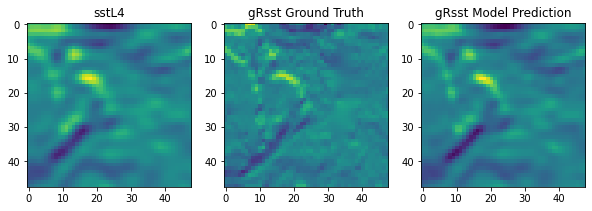

(2, 48, 48)


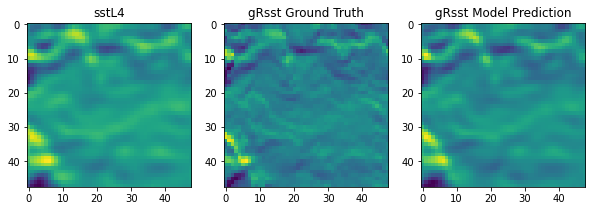

(2, 48, 48)


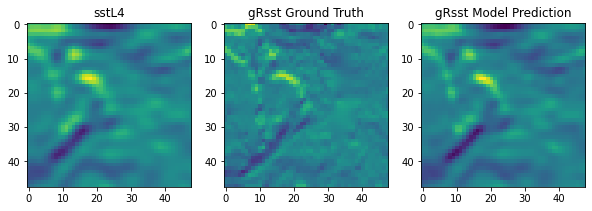

(2, 48, 48)


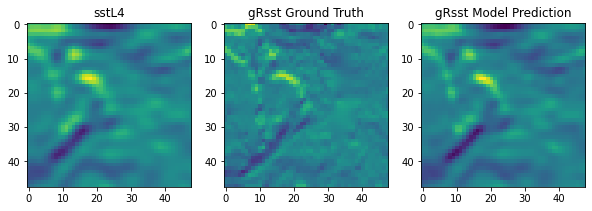

(2, 48, 48)


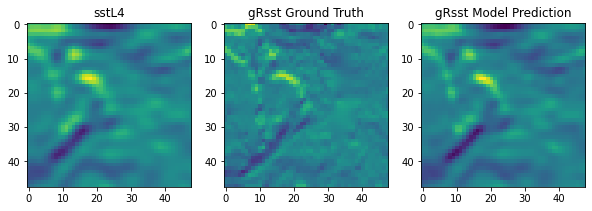

(2, 48, 48)


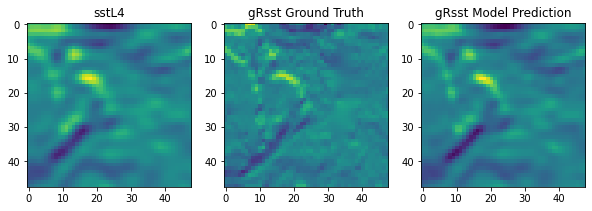

(2, 48, 48)


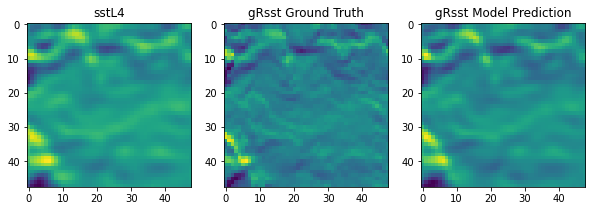

(2, 48, 48)


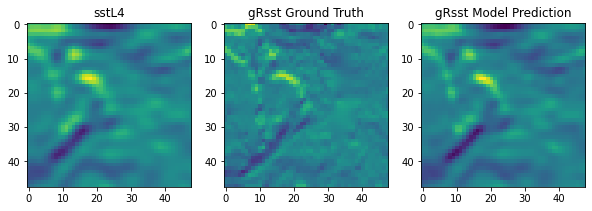

(2, 48, 48)


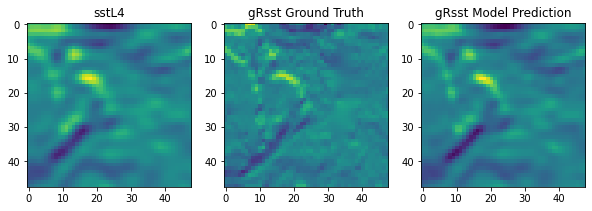

(2, 48, 48)


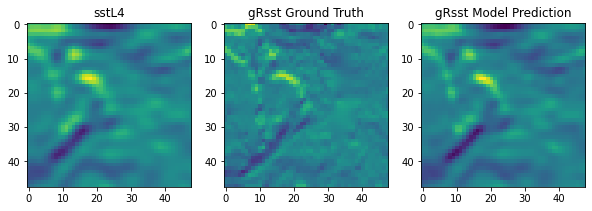

(2, 48, 48)


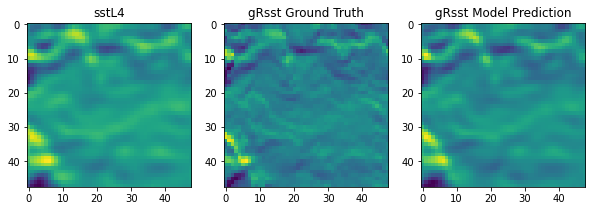

(2, 48, 48)


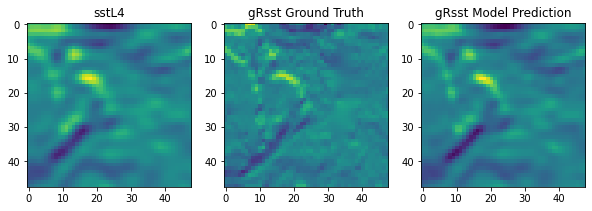

(2, 48, 48)


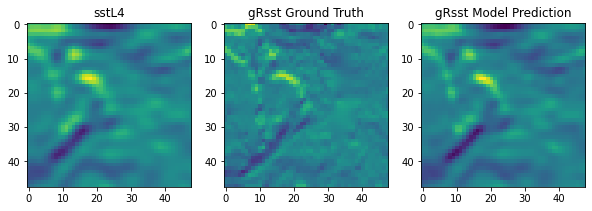

(2, 48, 48)


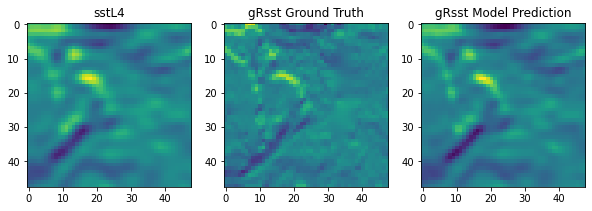

(2, 48, 48)


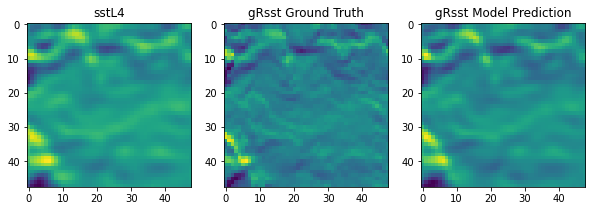

(2, 48, 48)


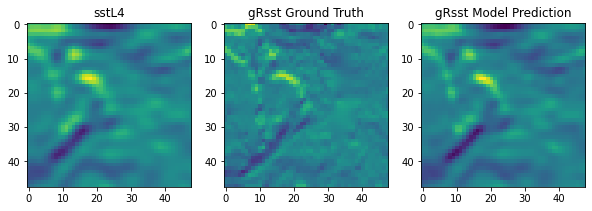

(2, 48, 48)


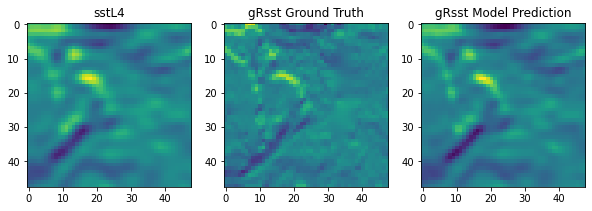

(2, 48, 48)


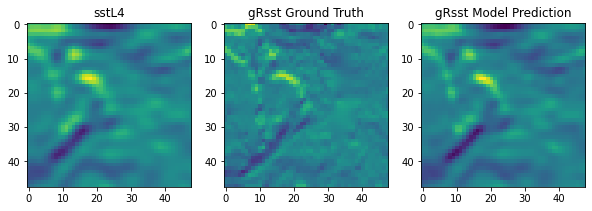

(2, 48, 48)


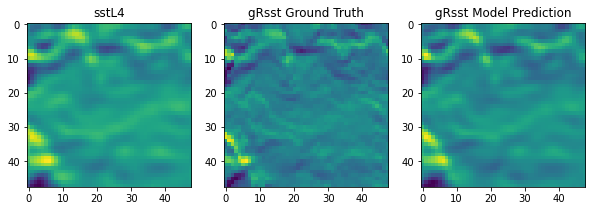

(2, 48, 48)


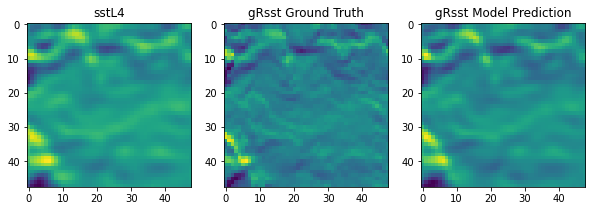

(2, 48, 48)


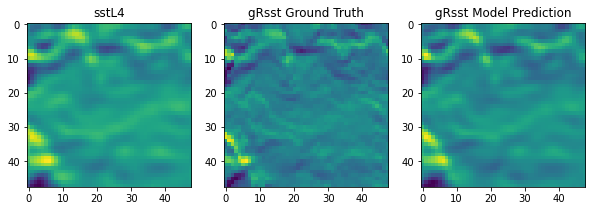

(2, 48, 48)


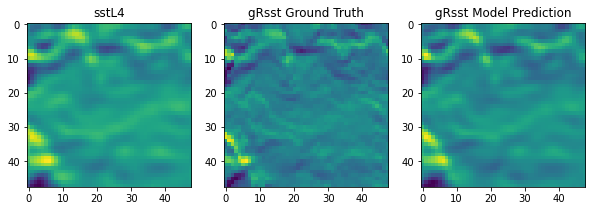

(2, 48, 48)


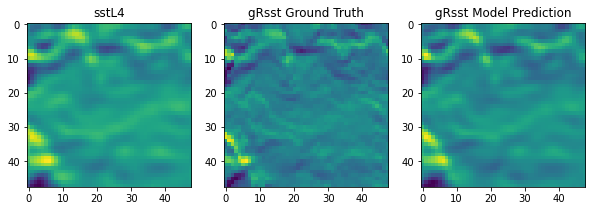

(2, 48, 48)


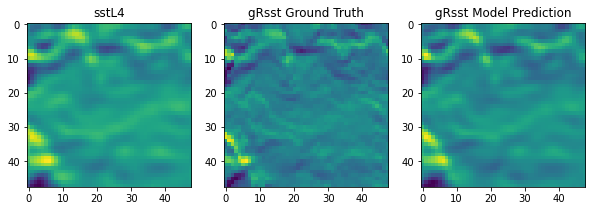

(2, 48, 48)


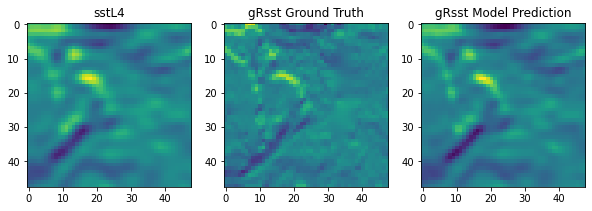

(2, 48, 48)


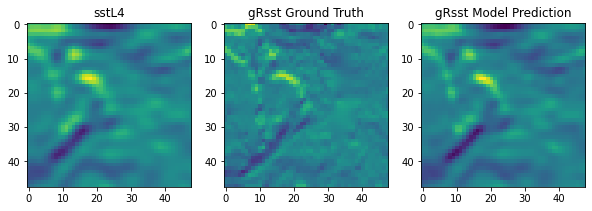

(2, 48, 48)


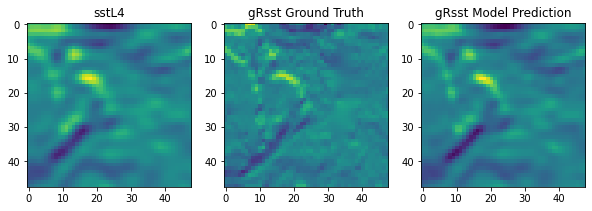

(2, 48, 48)


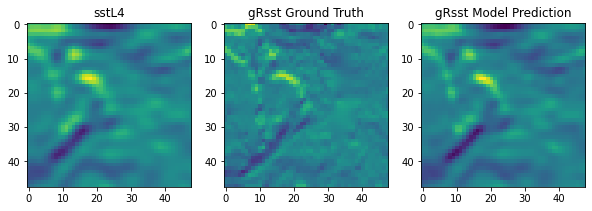

(2, 48, 48)


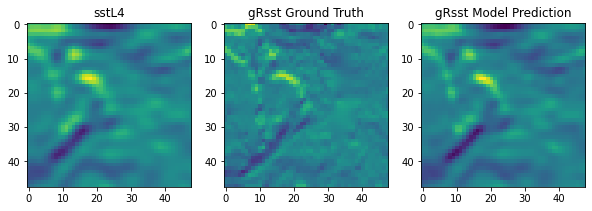

(2, 48, 48)


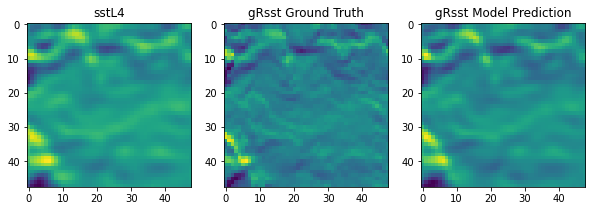

(2, 48, 48)


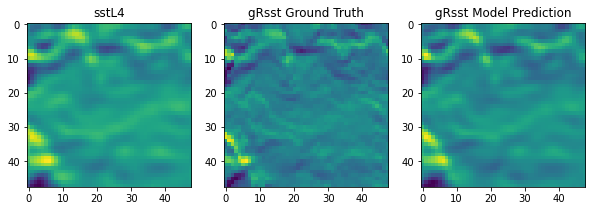

(2, 48, 48)


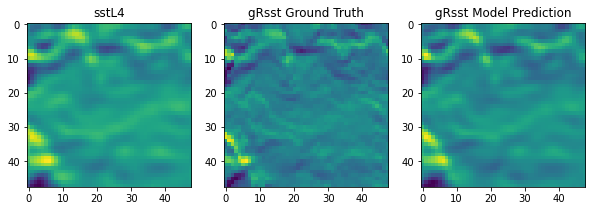

(2, 48, 48)


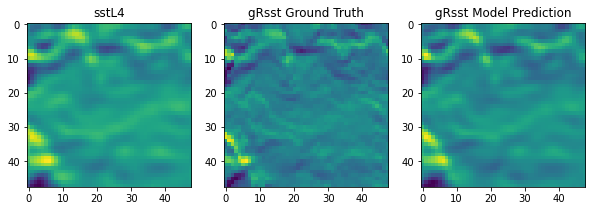

(2, 48, 48)


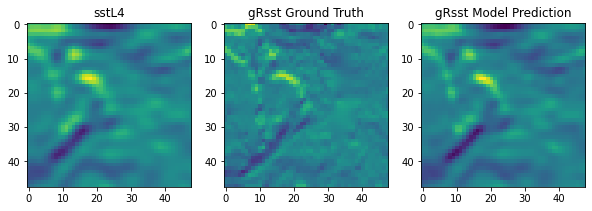

(2, 48, 48)


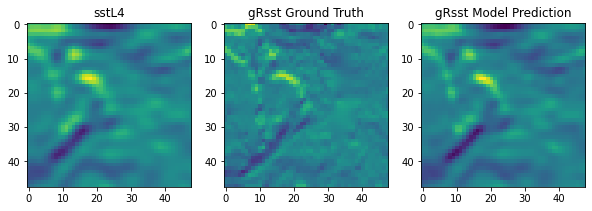

(2, 48, 48)


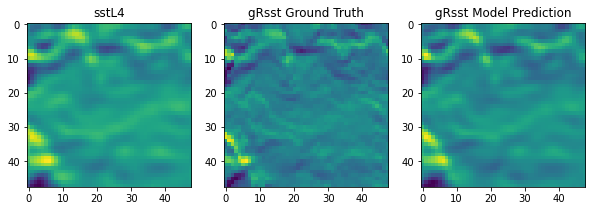

(2, 48, 48)


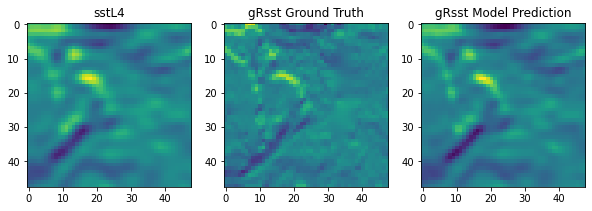

(2, 48, 48)


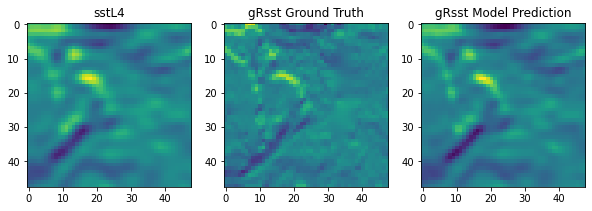

(2, 48, 48)


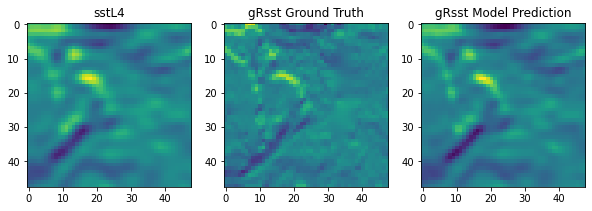

(2, 48, 48)


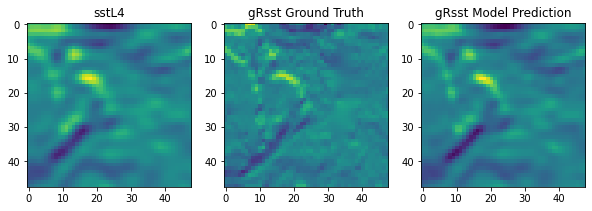

(2, 48, 48)


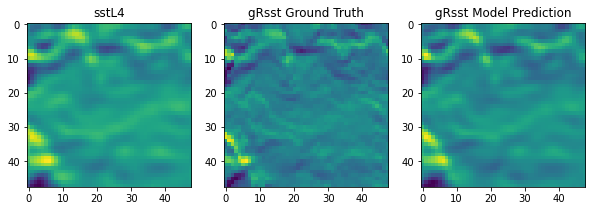

(2, 48, 48)


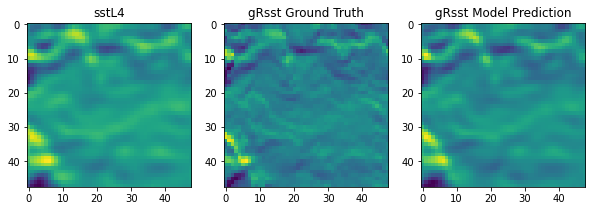

(2, 48, 48)


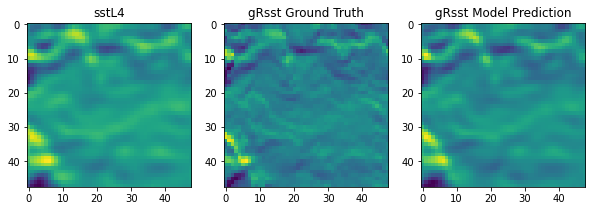

(2, 48, 48)


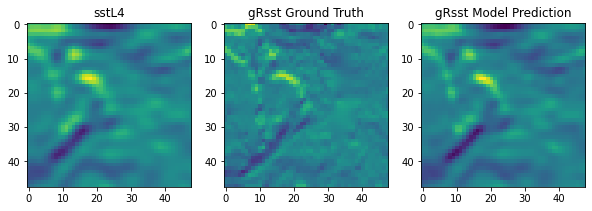

(2, 48, 48)


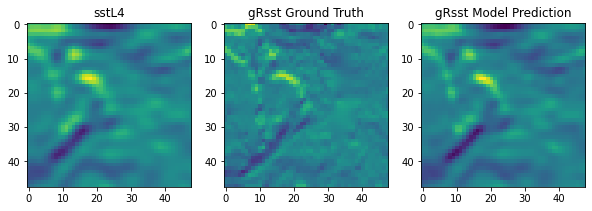

(2, 48, 48)


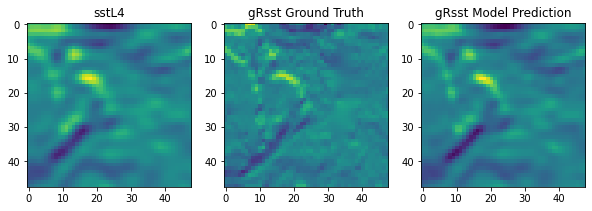

(2, 48, 48)


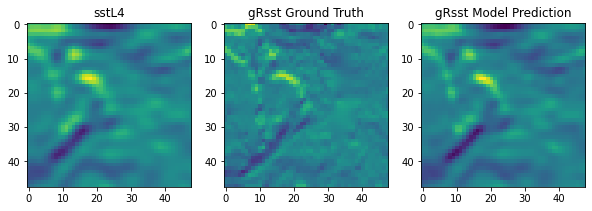

(2, 48, 48)


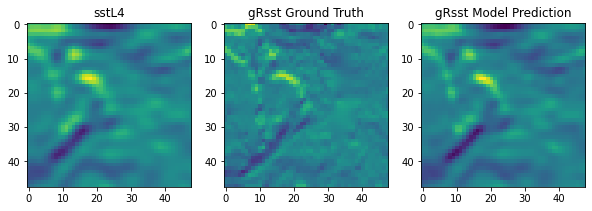

(2, 48, 48)


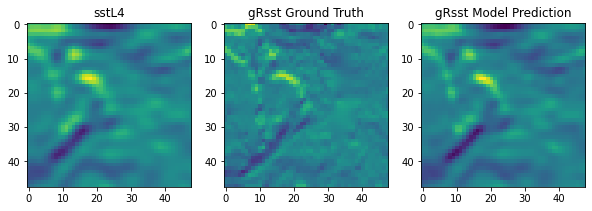

(2, 48, 48)


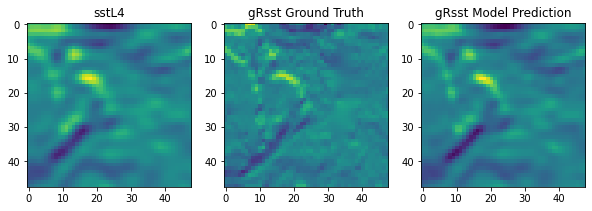

(2, 48, 48)


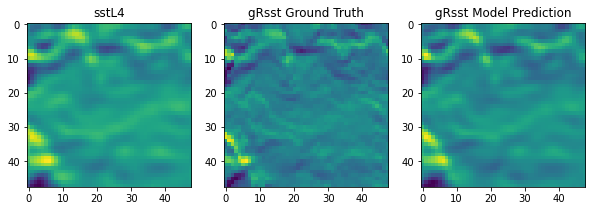

(2, 48, 48)


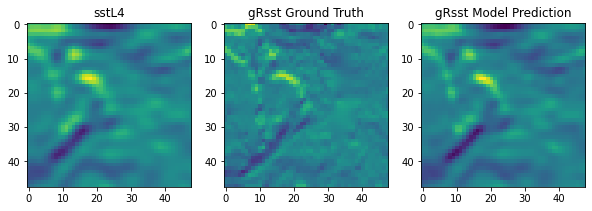

(2, 48, 48)


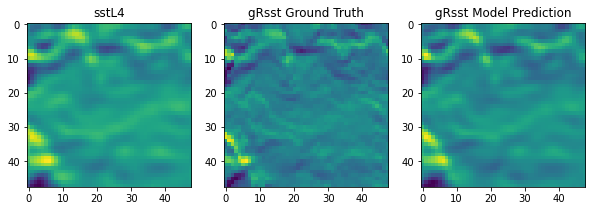

(2, 48, 48)


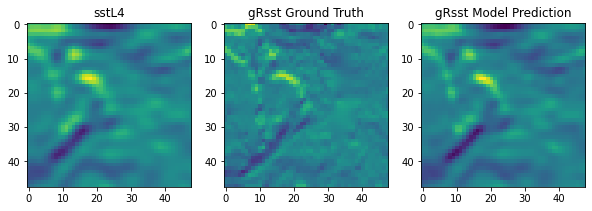

(2, 48, 48)


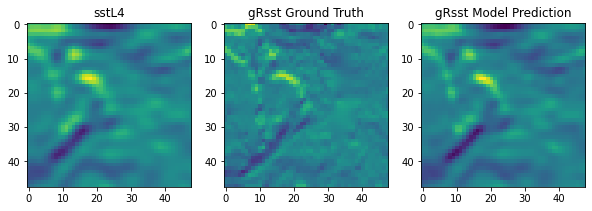

(2, 48, 48)


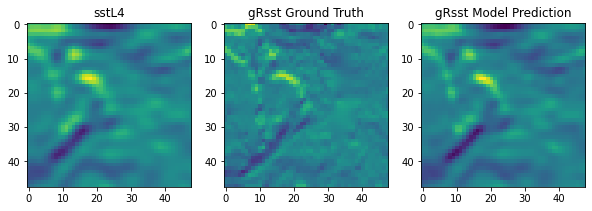

(2, 48, 48)


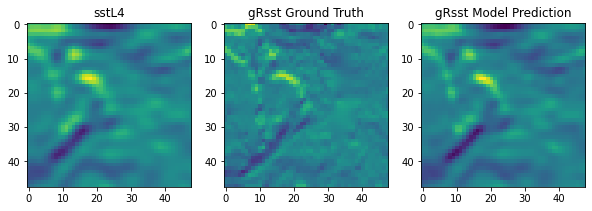

(2, 48, 48)


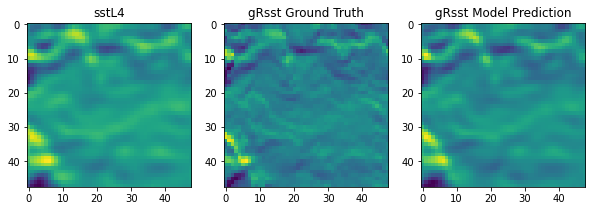

(2, 48, 48)


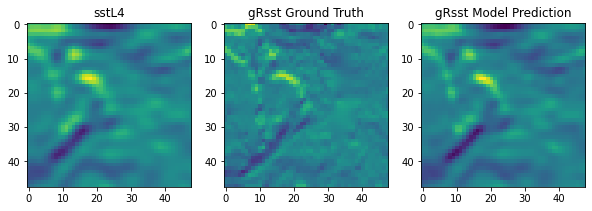

(2, 48, 48)


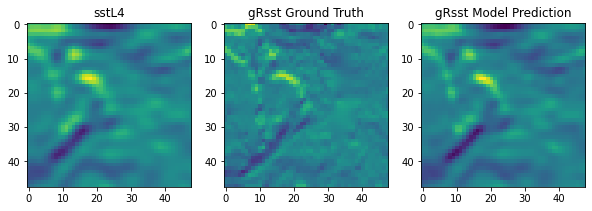

(2, 48, 48)


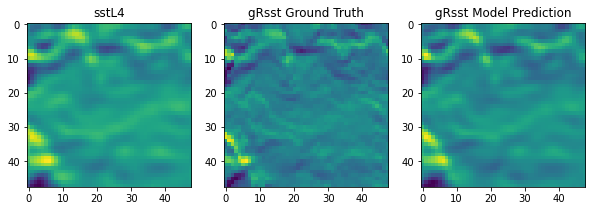

(2, 48, 48)


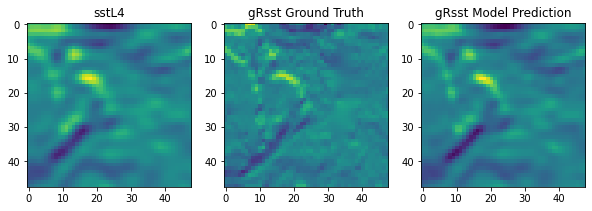

(2, 48, 48)


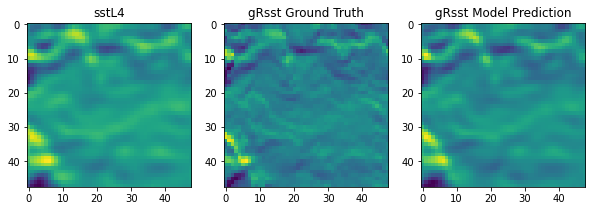

(2, 48, 48)


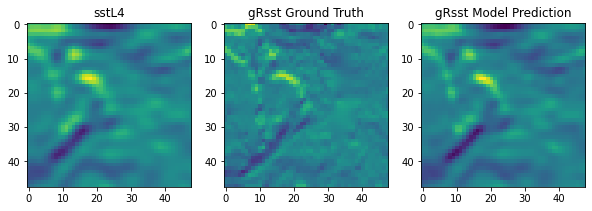

(2, 48, 48)


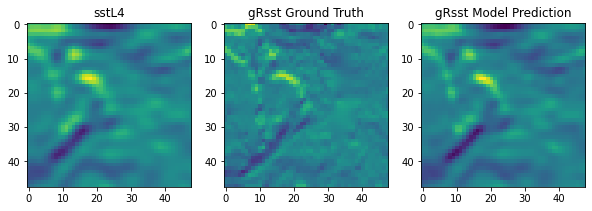

(2, 48, 48)


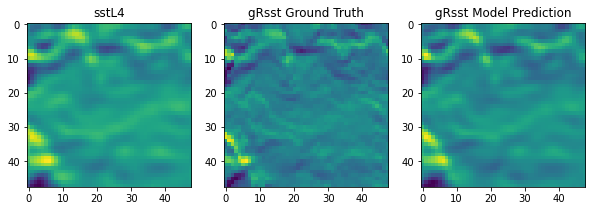

(2, 48, 48)


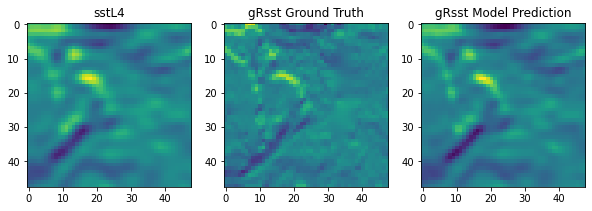

(2, 48, 48)


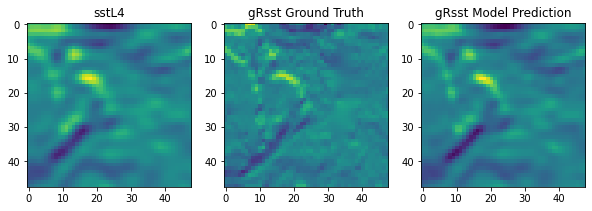

(2, 48, 48)


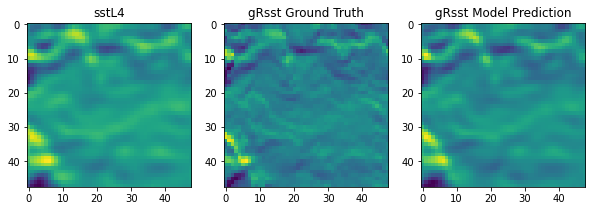

(2, 48, 48)


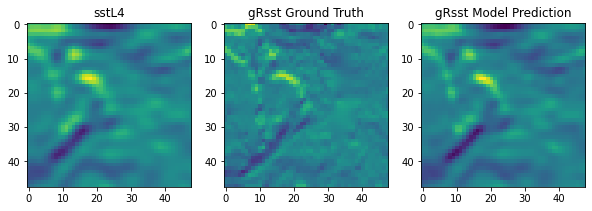

(2, 48, 48)


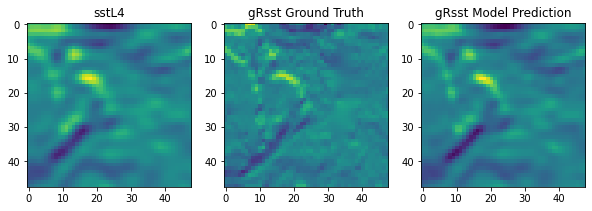

(2, 48, 48)


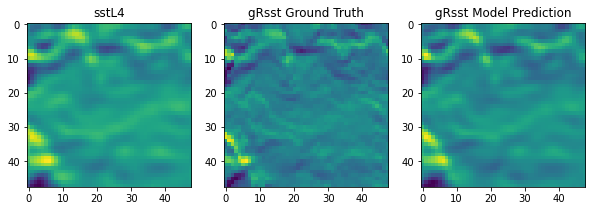

(2, 48, 48)


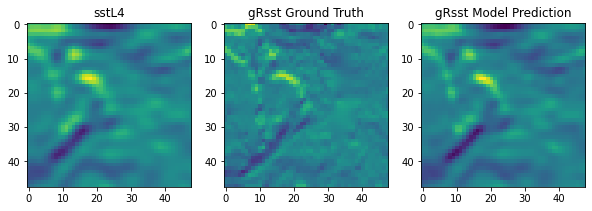

(2, 48, 48)


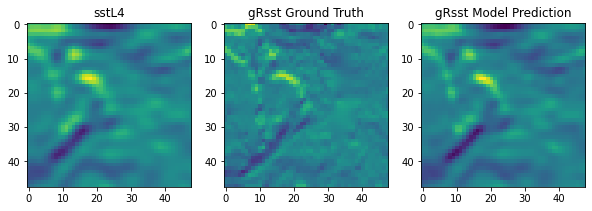

(2, 48, 48)


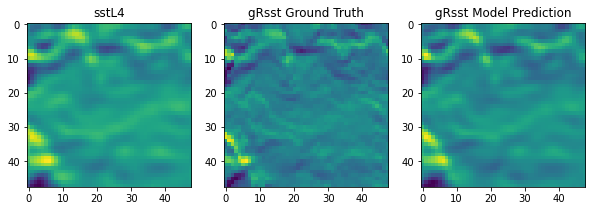

(2, 48, 48)


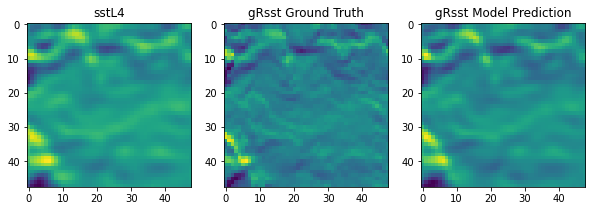

(2, 48, 48)


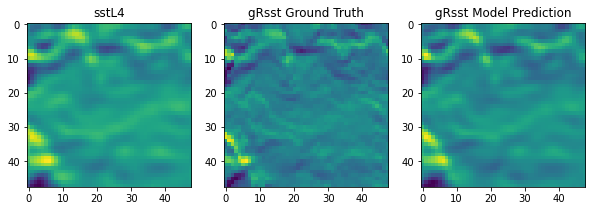

(2, 48, 48)


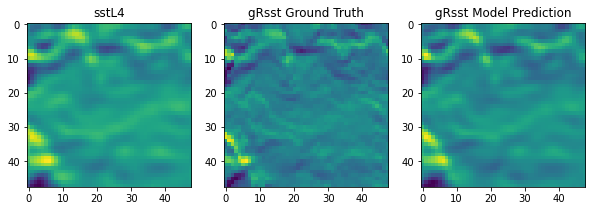

(2, 48, 48)


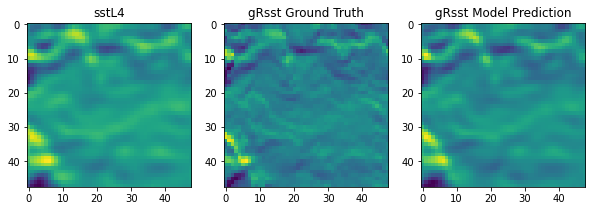

(2, 48, 48)


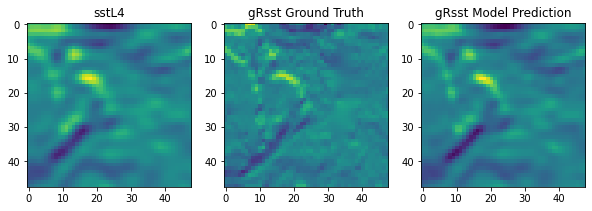

(2, 48, 48)


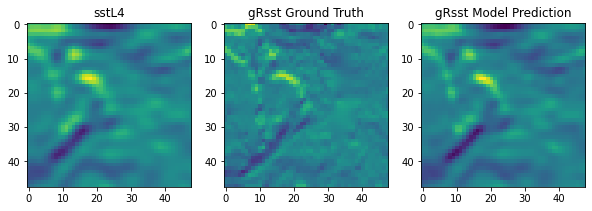

(2, 48, 48)


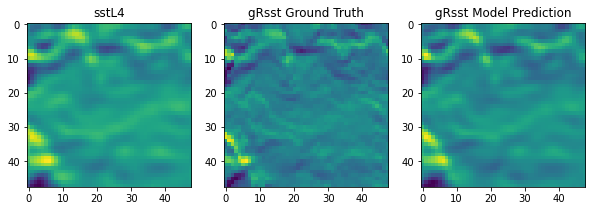

(2, 48, 48)


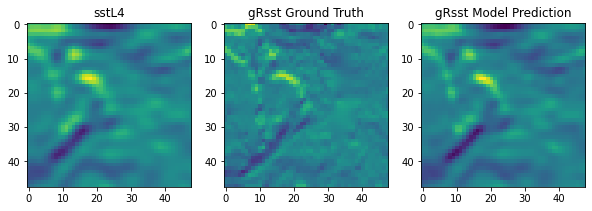

(2, 48, 48)


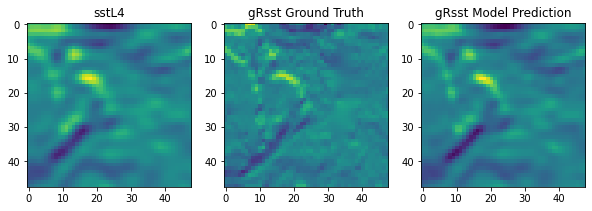

(2, 48, 48)


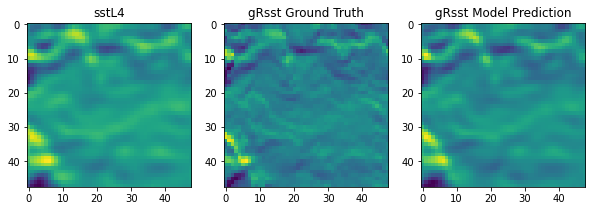

(2, 48, 48)


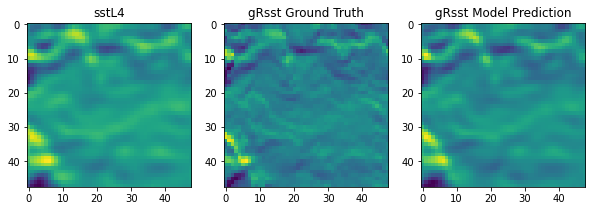

(2, 48, 48)


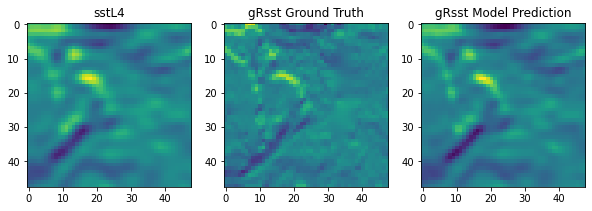

(2, 48, 48)


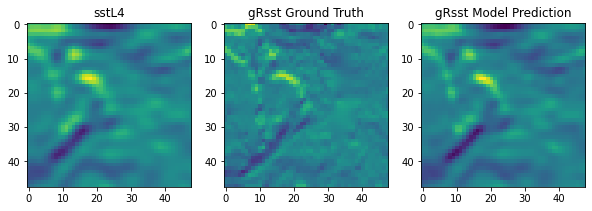

(2, 48, 48)


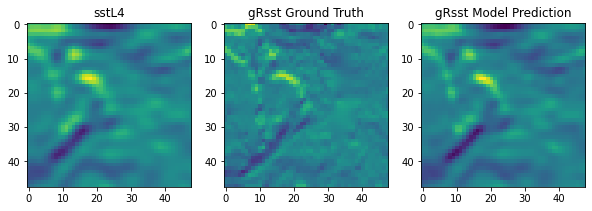

(2, 48, 48)


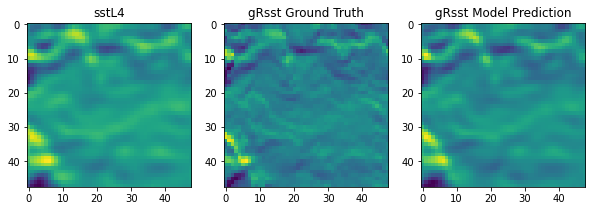

(2, 48, 48)


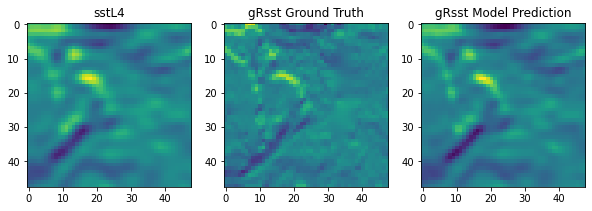

(2, 48, 48)


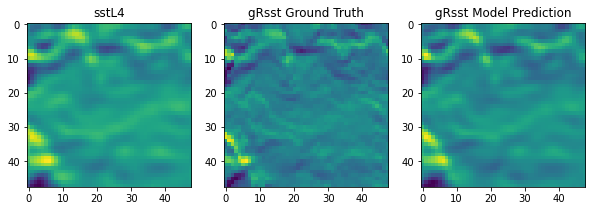

(2, 48, 48)


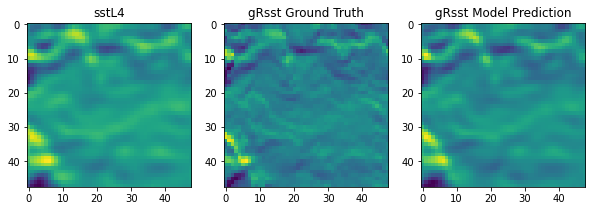

(2, 48, 48)


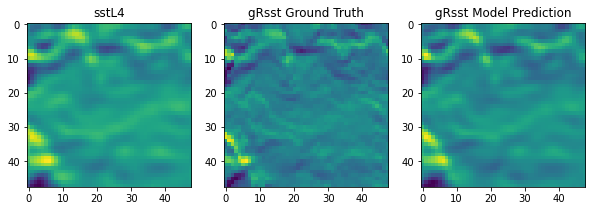

In [125]:
model = best_model
model.to(device)
input_data, output_data = next(iter(test_loader)) # single batch

N=100

for _ in range(N):
    randint = np.random.randint(0, len(input_data))
    sample_input = input_data[randint].to(device)
    sample_output = output_data[randint].detach().cpu().numpy()
    model.eval()
    with torch.no_grad():
        sample_prediction = model(sample_input).detach().cpu().numpy()
    sample_input = sample_input.detach().cpu().numpy()
    print(np.shape(sample_output))
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    ax[0].imshow(sample_input[1])
    ax[0].set_title('sstL4')
    ax[1].imshow(sample_output[1]) 
    ax[1].set_title('gRsst Ground Truth')
    ax[2].imshow(sample_prediction[1]) 
    ax[2].set_title('gRsst Model Prediction')
    fig.savefig('plots/SRCNN_example_output')
    plt.show()

In [ ]:
# test_running_loss = 0
# test_running_psnr = 0
# for i, (test_input, test_true) in enumerate(test_loader, 0): 
#     test_input = test_input.to(device)
#     test_true = test_true.to(device)
#     with torch.no_grad(): 
#         test_predicted = model(test_input)
#         test_running_loss += loss_fn(test_predicted, test_true)
#         test_running_psnr += PSNR(model, test_true.detach().cpu().numpy(), test_predicted.detach().cpu().numpy())
#         ground_truth = test_true.detach().cpu().numpy()
#         prediction = test_predicted.detach().cpu().numpy()
#         break